In [135]:
import codecs
import copy
import gc
import json
import logging
import os
import pickle
import random
import time
from typing import List, Tuple, Union
import xarray as xr

In [136]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [137]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import umap

In [138]:
from assessment import calc_uncertainty_regection_curve, f_beta_metrics
from uncertainty import ensemble_uncertainties_regression

In [139]:
try:
    from catboost import CatBoostRegressor
    CATBOOST_EXISTS = True
    print('CatBoost is installed')
except:
    CatBoostRegressor = None
    CATBOOST_EXISTS = False
    print('CatBoost is NOT installed')

CatBoost is installed


In [140]:
def build_preprocessor(X: np.ndarray, colnames: List[str]) -> Pipeline:
    X_ = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'scaler',
            MinMaxScaler()
        )
    ]).fit_transform(X)
    X_ = np.rint(X_ * 100000.0).astype(np.int32)
    binary_features = dict()
    categorical_features = dict()
    removed_features = []
    for col_idx in range(X.shape[1]):
        values = set(X_[:, col_idx].tolist())
        print(f'Column {col_idx} "{colnames[col_idx]}" has ' \
              f'{len(values)} unique values.')
        if len(values) > 1:
            if len(values) < 3:
                binary_features[col_idx] = np.min(X[:, col_idx])
            else:
                categorical_features[col_idx] = len(values)
        else:
            removed_features.append(col_idx)
        del values
    del X_
    all_features = set(range(X.shape[1]))
    useful_features = sorted(list(all_features - set(removed_features)))
    if len(useful_features) == 0:
        raise ValueError('Training inputs are bad. All features are removed.')
    print(f'There are {X.shape[1]} features.')
    if len(removed_features) > 0:
        print(f'These features will be removed: ' \
              f'{[colnames[col_idx] for col_idx in removed_features]}.')
    transformers = []
    if (len(categorical_features) > 0) and (len(binary_features) > 0):
        print(f'There are {len(categorical_features)} categorical ' \
              f'features and {len(binary_features)} binary features.')
    elif len(categorical_features) > 0:
        print(f'There are {len(categorical_features)} categorical features.')
    else:
        print(f'There are {len(binary_features)} binary features.')
    for col_idx in categorical_features:
        n_unique_values = categorical_features[col_idx]
        transformers.append(
            (
                colnames[col_idx],
                KBinsDiscretizer(
                    n_bins=min(max(n_unique_values // 3, 3), 256),
                    encode='ordinal',
                    strategy=('quantile' if n_unique_values > 50 else 'kmeans')
                ),
                (col_idx,)
            )
        )
    for col_idx in binary_features:
        transformers.append(
            (
                colnames[col_idx],
                Binarizer(threshold=0.0),
                (col_idx,)
            )
        )
    preprocessor = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'minmax_scaler',
            MinMaxScaler()
        ),
        (
            'composite_transformer', ColumnTransformer(
                transformers=transformers,
                sparse_threshold=0.0,
                n_jobs=1
            )
        ),
        (
            'selector',
            VarianceThreshold()
        ),
        (
            'standard_scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=42)
        )
    ])
    return preprocessor.fit(X)

In [141]:
def reduce_dimensions_of_data(features: np.ndarray) -> np.ndarray:
    preprocessed_features = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=features.shape[1] // 3,
                        random_state=42))
        ]
    ).fit_transform(features)
    print('Features are preprocessed.')
    reduced_features = umap.UMAP(
        low_memory=False,
        n_jobs=-1,
        random_state=42,
        verbose=True
    ).fit_transform(preprocessed_features)
    print('Feature space is reduced.')
    del preprocessed_features
    return reduced_features

In [142]:
def show_temperature(features: np.ndarray, targets: np.ndarray,
                     title: str='', figure_id: int=0):
    if features.shape[0] != targets.shape[0]:
        err_msg = f'Features do not correspond to targets! ' \
                  f'{features.shape[0]} != {targets.shape[0]}'
        raise ValueError(err_msg)
    if len(features.shape) != 2:
        err_msg = f'Features are wrong! Expected 2-D array, got ' \
                  f'{len(features.shape)}-D one.'
        raise ValueError(err_msg)
    if features.shape[1] != 2:
        err_msg = f'Features are wrong! Expected number of ' \
                  f'columns is 2, got {features.shape[1]}.'
        raise ValueError(err_msg)
    if len(targets.shape) != 1:
        err_msg = f'Targets are wrong! Expected 1-D array, got ' \
                  f'{len(targets.shape)}-D one.'
        raise ValueError(err_msg)
    sorted_targets = sorted(targets.tolist())
    n_percentile2 = max(int(round(0.01 * len(sorted_targets))), 1)
    min_target = sorted_targets[n_percentile2]
    max_target = sorted_targets[-n_percentile2]
    del sorted_targets
    clipped_targets = np.empty(targets.shape, dtype=np.float64)
    for sample_idx in range(targets.shape[0]):
        if targets[sample_idx] < min_target:
            clipped_targets[sample_idx] = min_target
        elif targets[sample_idx] > max_target:
            clipped_targets[sample_idx] = max_target
        else:
            clipped_targets[sample_idx] = targets[sample_idx]
    temperature_colors = clipped_targets.tolist()
    temperature_norm = Normalize(vmin=np.min(temperature_colors),
                                 vmax=np.max(temperature_colors))
    fig = plt.figure(figure_id, figsize=(11, 11))
    plt.scatter(x=features[:, 0], y=features[:, 1],
                marker='o', cmap=plt.cm.get_cmap("jet"), c=temperature_colors,
                norm=temperature_norm)
    if len(title) > 0:
        plt.title(f'UMAP projections of weather data {title} (temperature)')
    else:
        plt.title(f'UMAP projections of weather data (temperature)')
    plt.colorbar()
    plt.show()

In [143]:
def filter_dataset(y: np.ndarray) -> List[int]:
    all_values = sorted(y.tolist())
    n = len(all_values)
    if n <= 10000:
        err_msg = f'y is wrong! Expected length of y is greater than 10000, ' \
                  f'but got {n}.'
        raise ValueError(err_msg)
    y001 = all_values[int(round((n - 1) * 0.001))]
    y999 = all_values[int(round((n - 1) * 0.999))]
    del all_values
    filtered_indices = list(filter(
        lambda idx: (y[idx] > y001) and (y[idx] < y999),
        range(n)
    ))
    return filtered_indices

In [144]:
def build_neural_network(input_size: int, layer_size: int, n_layers: int,
                         dropout_rate: float, scale_coeff: float,
                         nn_name: str) -> tf.keras.Model:
    feature_vector = tf.keras.layers.Input(
        shape=(input_size,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    outputs = []
    hidden_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_dropout1'
    )(feature_vector)
    for layer_idx in range(1, (2 * n_layers) // 3 + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    projection_layer = tf.keras.layers.Dense(
        units=50,
        activation=None,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_projection'
    )(hidden_layer)
    for layer_idx in range((2 * n_layers) // 3 + 1, n_layers + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    output_layer = tf.keras.layers.Dense(
        units=2,
        activation=None,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_output'
    )(hidden_layer)
    bayesian_layer = tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.Normal(
            loc=t[..., :1],
            scale=1e-6 + tf.math.softplus((1.0 / scale_coeff) * t[..., 1:])
        ),
        name=f'{nn_name}_distribution'
    )(output_layer)
    neural_network = tf.keras.Model(
        inputs=feature_vector,
        outputs=[bayesian_layer, projection_layer],
        name=nn_name
    )
    neural_network.build(input_shape=(None, input_size))
    return neural_network

In [145]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1, comment: str=''):
    val_metric_name = 'val_' + metric_name
    if metric_name not in history.history:
        err_msg = f'The metric "{metric_name}" is not found! Available metrics are: ' \
                  f'{list(history.history.keys())}.'
        raise ValueError(err_msg)
    plt.figure(figure_id, figsize=(5, 5))
    interesting_metric = history.history[metric_name]
    plt.plot(list(range(len(interesting_metric))), interesting_metric,
             label=f'Training {metric_name}')
    if val_metric_name in history.history:
        interesting_val_metric = history.history[val_metric_name]
        assert len(interesting_metric) == len(interesting_val_metric)
        plt.plot(list(range(len(interesting_val_metric))),
                 interesting_val_metric,
                 label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    if len(comment) > 0:
        plt.title(f'Training process of {comment}')
    else:
        plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [146]:
def predict_with_single_nn(input_data: np.ndarray, model_for_prediction: tf.keras.Model,
                           batch_size: int, output_scaler: StandardScaler) \
        -> Tuple[np.ndarray, np.ndarray]:
    if len(input_data.shape) != 2:
        err_msg = f'The `input_data` argument is wrong! Expected 2-D array, ' \
                  f'got {len(input_data.shape)}-D one!'
        raise ValueError(err_msg)
    n_batches = int(np.ceil(input_data.shape[0] / float(batch_size)))
    pred_mean = []
    pred_std = []
    for batch_idx in range(n_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(input_data.shape[0], batch_start + batch_size)
        instant_predictions = model_for_prediction(input_data[batch_start:batch_end])[0]
        if not isinstance(instant_predictions, tfp.distributions.Distribution):
            err_msg = f'Minibatch {batch_idx}: predictions are wrong! ' \
                      f'Expected tfp.distributions.Distribution, ' \
                      f'got {type(instant_predictions)}.'
            raise ValueError(err_msg)
        instant_mean = instant_predictions.mean()
        instant_std = instant_predictions.stddev()
        del instant_predictions
        if not isinstance(instant_mean, np.ndarray):
            instant_mean = instant_mean.numpy()
        if not isinstance(instant_std, np.ndarray):
            instant_std = instant_std.numpy()
        instant_mean = instant_mean.astype(np.float64).flatten()
        instant_std = instant_std.astype(np.float64).flatten()
        pred_mean.append(instant_mean)
        pred_std.append(instant_std)
        del instant_mean, instant_std
    pred_mean = np.concatenate(pred_mean)
    pred_std = np.concatenate(pred_std)
    pred_mean = output_scaler.inverse_transform(
        pred_mean.reshape((input_data.shape[0], 1))
    ).flatten()
    pred_std *= output_scaler.scale_[0]
    return pred_mean, pred_std * pred_std

In [147]:
def evaluate_single_nn(pred_means: np.ndarray, pred_vars: np.ndarray,
                       true_outputs: np.ndarray) -> float:
    if len(pred_means.shape) != 1:
        err_msg = f'The `pred_means` argument is wrong! Expected 1-D array, ' \
                  f'got {len(pred_means.shape)}-D one.'
        raise ValueError(err_msg)
    if len(pred_vars.shape) != 1:
        err_msg = f'The `pred_vars` argument is wrong! Expected 1-D array, ' \
                  f'got {len(pred_vars.shape)}-D one.'
        raise ValueError(err_msg)
    if len(true_outputs.shape) != 1:
        err_msg = f'The `true_outputs` argument is wrong! Expected 1-D array, ' \
                  f'got {len(true_outputs.shape)}-D one.'
        raise ValueError(err_msg)
    n_test_samples = true_outputs.shape[0]
    if n_test_samples < 5:
        raise ValueError(f'Number of test samples = {n_test_samples} is too small!')
    if n_test_samples != pred_means.shape[0]:
        err_msg = f'The `pred_means` does not correspond to the `true_outputs`! ' \
                  f'{pred_means.shape[0]} != {n_test_samples}'
        raise ValueError(err_msg)
    if n_test_samples != pred_vars.shape[0]:
        err_msg = f'The `pred_vars` does not correspond to the `true_outputs`! ' \
                  f'{pred_vars.shape[0]} != {n_test_samples}'
        raise ValueError(err_msg)
    
    all_preds_ = np.empty((1, n_test_samples, 2), dtype=np.float32)
    all_preds_[0, :, 0] = pred_means
    all_preds_[0, :, 1] = pred_vars
    all_uncertainty_ = ensemble_uncertainties_regression(all_preds_)
    uncertainties = all_uncertainty_['tvar']
    del all_preds_, all_uncertainty_
    
    errors = (pred_means - true_outputs) ** 2
    rejection_mse_ = calc_uncertainty_regection_curve(errors, uncertainties)
    return np.mean(rejection_mse_)

In [148]:
def predict_by_ensemble(input_data: np.ndarray,
                        preprocessing: Pipeline,
                        ensemble: List[tf.keras.Model],
                        postprocessing: List[StandardScaler],
                        minibatch: int) -> np.ndarray:
    num_samples = input_data.shape[0]
    ensemble_size = len(postprocessing)
    if ensemble_size != len(ensemble):
        err_msg = f'Ensemble of preprocessors does not correspond to ' \
                  f'ensemble of models! {ensemble_size} != {len(ensemble)}'
        raise ValueError(err_msg)
    predictions_of_ensemble = np.empty((ensemble_size, num_samples, 2),
                                       dtype=np.float64)
    X = preprocessing.transform(input_data).astype(np.float32)
    for model_idx, (cur_model, post_) in enumerate(zip(ensemble, postprocessing)):
        y_mean, y_var = predict_with_single_nn(
            input_data=X,
            model_for_prediction=cur_model,
            output_scaler=post_,
            batch_size=minibatch
        )
        predictions_of_ensemble[model_idx, :, 0] = y_mean
        predictions_of_ensemble[model_idx, :, 1] = y_var
    return predictions_of_ensemble

In [149]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [150]:
data_dir = os.path.join('data', 'yandex-shifts', 'weather')
print(f'{data_dir} {os.path.isdir(data_dir)}')

data\yandex-shifts\weather True


In [151]:
model_dir = os.path.join('models', 'yandex-shifts', 'weather', 'S')
print(f'{model_dir} {os.path.isdir(model_dir)}')

models\yandex-shifts\weather\S True


In [152]:
baseline_model_dir = os.path.join('models', 'yandex-shifts',
                                  'weather-baseline-catboost')
print(f'{baseline_model_dir} {os.path.isdir(baseline_model_dir)}')

models\yandex-shifts\weather-baseline-catboost True


In [153]:
dev_in_name = os.path.join(data_dir, 'x_val_cube.zarr')
print(f'{dev_in_name} {os.path.isfile(dev_in_name)}')

data\yandex-shifts\weather\x_val_cube.zarr False


In [154]:
dev_out_name = os.path.join(data_dir, 'y_val_cube.zarr')
print(f'{dev_out_name} {os.path.isfile(dev_out_name)}')

data\yandex-shifts\weather\y_val_cube.zarr False


In [155]:
eval_name = os.path.join(data_dir, 'x_test_cube.zarr')
print(f'{eval_name} {os.path.isfile(eval_name)}')

data\yandex-shifts\weather\x_test_cube.zarr False


In [193]:
eval_output_name= os.path.join(data_dir, 'y_test_cube.zarr')
print(f'{eval_name} {os.path.isfile(eval_name)}')

data\yandex-shifts\weather\x_test_cube.zarr False


In [156]:
preprocessing_name = os.path.join(model_dir, 'preprocessing_pipeline.pkl')
with open(preprocessing_name, 'rb') as fp:
    common_preprocessor = pickle.load(fp)

In [157]:
print(common_preprocessor)

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=-1.0, strategy='constant')),
                ('minmax_scaler', MinMaxScaler()),
                ('composite_transformer',
                 ColumnTransformer(n_jobs=1, sparse_threshold=0.0,
                                   transformers=[('10_metre_u_wind_component',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=256),
                                                  (0,)),
                                                 ('10_metre_v_wind_component',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=...
                                                  (16,)),
                                                 ('v_component_of_wind_h180',
                                                  KBinsDiscret

In [158]:
config_name = os.path.join(model_dir, 'weather_snn_config.json')
with codecs.open(config_name, mode='r', encoding='utf-8') as fp:
    nn_ens_hyperparams = json.load(fp)
num_features = nn_ens_hyperparams['input_size']
ensemble_size = nn_ens_hyperparams['ensemble_size']
nn_layer_size = nn_ens_hyperparams['layer_size']
nn_depth = nn_ens_hyperparams['n_layers']
nn_dropout = nn_ens_hyperparams['alpha_dropout_rate']

In [159]:
postprocessing_name = os.path.join(model_dir, 'postprocessing_scalers.pkl')
with open(postprocessing_name, 'rb') as fp:
    postprocessing_scalers = pickle.load(fp)
if len(postprocessing_scalers) != ensemble_size:
    err_msg_ = f'Postprocessors do not correspond to NN ensemble! ' \
               f'{len(postprocessing_scalers)} != {ensemble_size}'
    raise ValueError(err_msg_)

In [160]:
deep_ensemble = []
BATCH_SIZE = 4096
new_figure_id = 0

In [161]:
for nn_idx in range(ensemble_size):
    model_name = f'weather_snn_{nn_idx + 1}'
    serialization_name = os.path.join(model_dir, model_name + '.h5')
    regression_output_name = f'{model_name}_distribution'
    projection_output_name = f'{model_name}_projection'
    printable_name = f'Self-Normalizing Network ' \
                     f'{nn_idx + 1} for weather prediction'
    print('========================================')
    print(' ' + printable_name)
    print('========================================')
    print('')
    new_model = build_neural_network(
        input_size=num_features,
        layer_size=nn_layer_size,
        n_layers=nn_depth,
        dropout_rate=nn_dropout,
        scale_coeff=postprocessing_scalers[nn_idx].scale_[0],
        nn_name=model_name
    )
    new_model.summary()
    print('')
    new_model.load_weights(serialization_name)
    deep_ensemble.append(new_model)
    del new_model

 Self-Normalizing Network 1 for weather prediction

Model: "weather_snn_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 weather_snn_1_feature_vector (  [(None, 20)]        0           []                               
 InputLayer)                                                                                      
                                                                                                  
 weather_snn_1_dropout1 (AlphaD  (None, 20)          0           ['weather_snn_1_feature_vector[0]
 ropout)                                                         [0]']                            
                                                                                                  
 weather_snn_1_dense1 (Dense)   (None, 512)          10752       ['weather_snn_1_dropout1[0][0]'] 
                                  

In [238]:
skiron_cube= xr.open_zarr(dev_in_name)
mito_cube= xr.open_zarr(dev_out_name)

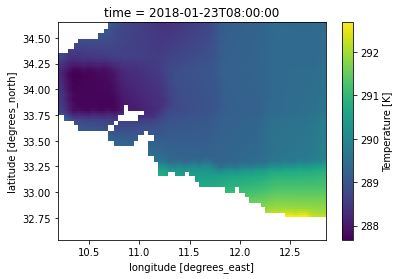

In [239]:
skiron_cube.temperature[0].plot()

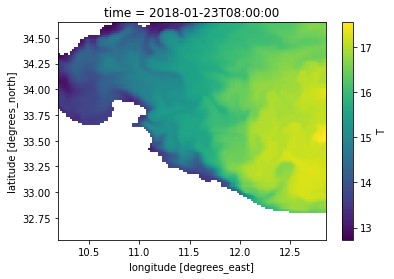

In [240]:
mito_cube.T[0].plot()

In [236]:
df_in = xr.open_zarr(dev_in_name).to_dataframe().dropna()#pd.read_csv(dev_in_name)
print(f'Row number is {df_in.shape[0]}.')
print(f'Column number is {df_in.shape[1]}.')

Row number is 1322863.
Column number is 20.


In [232]:
df_in.head()

10_metre_u_wind_component  \
time                lat       lon                                    
2018-01-23 08:00:00 34.641532 10.203631                        NaN   
                              10.223593                        NaN   
                              10.243556                        NaN   
                              10.263518                        NaN   
                              10.283480                        NaN   

                                         10_metre_v_wind_component  \
time                lat       lon                                    
2018-01-23 08:00:00 34.641532 10.203631                        NaN   
                              10.223593                        NaN   
                              10.243556                        NaN   
                              10.263518                        NaN   
                              10.283480                        NaN   

                                         2_metre_temperature  evaporation  \
time                lat       lon                                           
2018-01-23 08:00:00 34.641532 10.203631                  NaN          NaN   
                              10.223593                  NaN          NaN   
                              10.243556                  NaN          NaN   
                              10.263518                  NaN          NaN   
                              10.283480                  NaN          NaN   

                                         latent_heat_flux  \
time                lat       lon                           
2018-01-23 08:00:00 34.641532 10.203631               NaN   
                              10.223593               NaN   
                              10.243556               NaN   
                              10.263518               NaN   
                              10.283480               NaN   

                                         mean_sea_level_pressure  \
time                lat       lon                                  
2018-01-23 08:00:00 34.641532 10.203631                      NaN   
                              10.223593                      NaN   
                              10.243556                      NaN   
                              10.263518                      NaN   
                              10.283480                      NaN   

                                         sensible_heat_flux  \
time                lat       lon                             
2018-01-23 08:00:00 34.641532 10.203631                 NaN   
                              10.223593                 NaN   
                              10.243556                 NaN   
                              10.263518                 NaN   
                              10.283480                 NaN   

                                         specific_humidity  temperature  \
time                lat       lon                                         
2018-01-23 08:00:00 34.641532 10.203631                NaN          NaN   
                              10.223593                NaN          NaN   
                              10.243556                NaN          NaN   
                              10.263518                NaN          NaN   
                              10.283480                NaN          NaN   

                                         total_cloud_cover  \
time                lat       lon                            
2018-01-23 08:00:00 34.641532 10.203631                NaN   
                              10.223593                NaN   
                              10.243556                NaN   
                              10.263518                NaN   
                              10.283480                NaN   

                                         total_precipitation  \
time                lat       lon                              
2018-01-23 08:00:00 34.641532 10.203631                  NaN   
                   

In [237]:
df_out = xr.open_zarr(dev_out_name).to_dataframe().dropna()#pd.read_csv(dev_out_name)
print(f'Row number is {df_out.shape[0]}.')
print(f'Column number is {df_out.shape[1]}.')

Row number is 1237656.
Column number is 5.


In [233]:
df_out

Eta   S   T   U   V
time                lat       lon                           
2018-01-23 08:00:00 34.641532 10.203631  NaN NaN NaN NaN NaN
                              10.223593  NaN NaN NaN NaN NaN
                              10.243556  NaN NaN NaN NaN NaN
                              10.263518  NaN NaN NaN NaN NaN
                              10.283480  NaN NaN NaN NaN NaN
...                                      ...  ..  ..  ..  ..
2018-01-29 02:00:00 32.545494 12.758801  NaN NaN NaN NaN NaN
                              12.778763  NaN NaN NaN NaN NaN
                              12.798726  NaN NaN NaN NaN NaN
                              12.818688  NaN NaN NaN NaN NaN
                              12.838650  NaN NaN NaN NaN NaN

[1959622 rows x 5 columns]

In [166]:
'''inputs = np.vstack([
    df_in.iloc[:, 6:].to_numpy().astype(np.float64),
    df_out.iloc[:, 6:].to_numpy().astype(np.float64)
])
targets = np.concatenate([
    df_in['fact_temperature'].to_numpy().astype(np.float64),
    df_out['fact_temperature'].to_numpy().astype(np.float64)
])'''

"inputs = np.vstack([\n    df_in.iloc[:, 6:].to_numpy().astype(np.float64),\n    df_out.iloc[:, 6:].to_numpy().astype(np.float64)\n])\ntargets = np.concatenate([\n    df_in['fact_temperature'].to_numpy().astype(np.float64),\n    df_out['fact_temperature'].to_numpy().astype(np.float64)\n])"

In [167]:
df_out= df_out[['S']]
df_out.head()

S
time                lat       lon           
2018-01-23 08:00:00 34.641532 10.203631  0.0
                              10.223593  0.0
                              10.243556  0.0
                              10.263518  0.0
                              10.283480  0.0

In [168]:
inputs = df_in.to_numpy().astype(np.float64)
targets = df_out.to_numpy().astype(np.float64)
targets = targets.ravel()

In [169]:
start_inference_time = time.time()
all_preds = predict_by_ensemble(
    input_data=inputs,
    preprocessing=common_preprocessor,
    postprocessing=postprocessing_scalers,
    ensemble=deep_ensemble,
    minibatch=BATCH_SIZE
)
end_inference_time = time.time()
inference_duration = end_inference_time - start_inference_time
inference_duration *= 1000.0
print('The system predicts each sample from devset in ' \
      '{0:.3f} msecs.'.format(inference_duration / inputs.shape[0]))

The system predicts each sample from devset in 0.450 msecs.


In [227]:
all_preds

array([[[ 0.13607074, 13.16541692],
        [ 0.13607074, 13.16541692],
        [ 0.13607074, 13.16541692],
        ...,
        [ 0.13607074, 13.16541692],
        [ 0.13607074, 13.16541493],
        [ 0.13607074, 13.16541493]],

       [[ 0.26448672, 10.58750791],
        [ 0.26448672, 10.58750791],
        [ 0.26448672, 10.58750791],
        ...,
        [ 0.26448672, 10.58750791],
        [ 0.26448672, 10.58750612],
        [ 0.26448672, 10.58750612]],

       [[ 0.15523938, 11.49165631],
        [ 0.15523938, 11.49165631],
        [ 0.15523938, 11.49165631],
        ...,
        [ 0.15523938, 11.49165631],
        [ 0.15523938, 11.49165631],
        [ 0.15523938, 11.49165631]],

       [[ 0.13545691, 11.28180014],
        [ 0.13545691, 11.28180014],
        [ 0.13545691, 11.28180014],
        ...,
        [ 0.13545691, 11.28180014],
        [ 0.13545691, 11.28180014],
        [ 0.13545691, 11.28180014]],

       [[ 0.13518752, 13.13889051],
        [ 0.13518752, 13.13889051],
    

In [170]:
all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

In [171]:
all_preds_mean = all_preds[:,:,0]
avg_preds = np.squeeze(np.mean(all_preds_mean, axis=0))
errors = (avg_preds - targets) ** 2

In [228]:
errors

array([0.02732021, 0.02732021, 0.02732021, ..., 0.02732021, 0.02732021,
       0.02732021])

In [172]:
rejection_mse = calc_uncertainty_regection_curve(errors, uncertainties)
retention_mse = rejection_mse[::-1]
retention_fractions = np.linspace(0, 1, len(retention_mse))

In [173]:
print(f'R-AUC MSE = {np.mean(retention_mse)}.')

R-AUC MSE = 3.005641685270945.


In [174]:
if CATBOOST_EXISTS and os.path.isdir(baseline_model_dir):
    catboost_ensemble_size = 10
    all_catboost_preds = []
    for catboost_ind in range(1, catboost_ensemble_size + 1):
        new_catboost = CatBoostRegressor()
        cur_catboost_name = os.path.join(
            baseline_model_dir,
            f'seed{catboost_ind}.cbm'
        )
        print(f'{cur_catboost_name} = {os.path.isfile(cur_catboost_name)}')
        new_catboost.load_model(cur_catboost_name)
        print(f'CatBoost {catboost_ind} is loaded from {cur_catboost_name}.')
        new_catboost_preds = new_catboost.predict(inputs)
        if not isinstance(new_catboost_preds, np.ndarray):
            new_catboost_preds = np.asarray(new_catboost_preds)
        all_catboost_preds.append(new_catboost_preds)
        del new_catboost_preds, new_catboost
        print(f'CatBoost {catboost_ind} predicts on devset.')
        print('')
    all_catboost_preds = np.stack(all_catboost_preds, axis=0)
    all_uncertainty_catboost = ensemble_uncertainties_regression(all_catboost_preds)
    catboost_uncertainties = all_uncertainty_catboost['tvar']
    all_catboost_preds_mean = all_catboost_preds[:,:,0]
    avg_catboost_preds = np.squeeze(np.mean(all_catboost_preds_mean, axis=0))
    catboost_errors = (avg_catboost_preds - targets) ** 2
    catboost_rejection_mse = calc_uncertainty_regection_curve(
        catboost_errors,
        catboost_uncertainties
    )
    catboost_rejection_mse = catboost_rejection_mse[::-1]
    if len(retention_mse) != len(catboost_rejection_mse):
        err_msg_ = f'Predictions of our models do not correspond ' \
                   f'to predictions of baseline models! ' \
                   f'{len(retention_mse)} != {len(catboost_rejection_mse)}'
        raise ValueError(err_msg_)
    print(f'R-AUC MSE of CatBoost Ens = {np.mean(catboost_rejection_mse)}.')
else:
    catboost_rejection_mse = None

models\yandex-shifts\weather-baseline-catboost\seed1.cbm = False


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/model/model_import_interface.h:19: Model file doesn't exist: models\yandex-shifts\weather-baseline-catboost\seed1.cbm

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


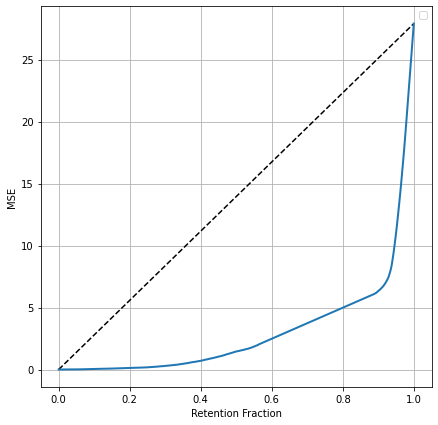

<Figure size 432x288 with 0 Axes>

In [176]:
catboost_rejection_mse = None
plt.figure(new_figure_id, figsize=(7, 7))
new_figure_id += 1
if catboost_rejection_mse is None:
    plt.plot([0, 1], [0, retention_mse[-1]], 'k--')
    plt.plot(retention_fractions, retention_mse, linewidth=2)
else:
    last_mse = max(retention_mse[-1], catboost_rejection_mse[-1])
    plt.plot(
        [0, 1],
        [0, last_mse],
        'k--'
    )
    if last_mse > retention_mse[-1]:
        plt.plot(
            retention_fractions.tolist() + [retention_fractions[-1]],
            retention_mse.tolist() + [last_mse],
            color='red', linewidth=2, label='Our deep ensemble'
        )
    else:
        plt.plot(
            retention_fractions,
            retention_mse,
            color='red', linewidth=2, label='Our deep ensemble'
        )
    if last_mse > catboost_rejection_mse[-1]:
        plt.plot(
            retention_fractions,
            catboost_rejection_mse,
            color='blue', linewidth=2, label='CatBoost ensemble baseline'
        )
    else:
        plt.plot(
            retention_fractions.tolist() + [retention_fractions[-1]],
            catboost_rejection_mse.tolist() + [last_mse],
            color='blue', linewidth=2, label='CatBoost ensemble baseline'
        )
plt.ylabel('MSE')
plt.xlabel('Retention Fraction')
plt.grid()
plt.legend(loc='best')
plt.show()
plt.clf()

In [177]:
thresh = 1.0
f_auc, f95, retention_f1 = f_beta_metrics(errors, uncertainties, thresh, beta=1.0)
print(f'F1 score at 95% retention: {f95}')
retention_fractions = np.linspace(0, 1, len(retention_f1))

F1 score at 95% retention: 0.9594984060603792


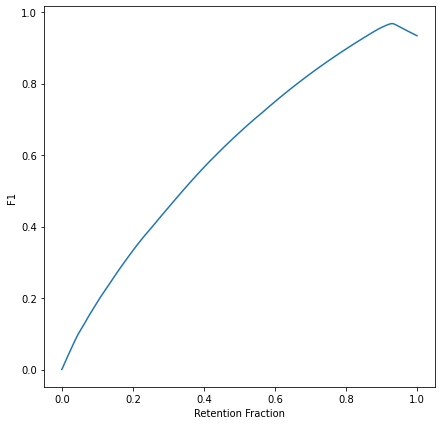

<Figure size 432x288 with 0 Axes>

In [178]:
plt.figure(new_figure_id, figsize=(7, 7))
new_figure_id += 1
plt.plot(retention_fractions, retention_f1)
plt.ylabel('F1')
plt.xlabel('Retention Fraction')
plt.show()
plt.clf()

In [179]:
ids = np.arange(1, inputs.shape[0] + 1)
preds = np.mean(all_preds[:,:,0], axis=0)
df_submission = pd.DataFrame(data={
    'ID' : ids,
    'PRED' : preds,
    'UNCERTAINTY' : uncertainties
})

In [180]:
df_submission.head()

,ID,PRED,UNCERTAINTY
0,1,0.165288,11.935573
1,2,0.165288,11.935573
2,3,0.165288,11.935573
3,4,0.165288,11.935573
4,5,0.165288,11.935573


In [182]:
out_file = os.path.join(model_dir, 'df_submission_dev.csv')
df_submission.to_csv(out_file, index=False)

In [184]:
df_eval = xr.open_zarr(eval_name).to_dataframe().fillna(0)
df_eval.head()

10_metre_u_wind_component  \
time                lat       lon                                    
2018-01-29 03:00:00 34.641532 10.203631                        0.0   
                              10.223593                        0.0   
                              10.243556                        0.0   
                              10.263518                        0.0   
                              10.283480                        0.0   

                                         10_metre_v_wind_component  \
time                lat       lon                                    
2018-01-29 03:00:00 34.641532 10.203631                        0.0   
                              10.223593                        0.0   
                              10.243556                        0.0   
                              10.263518                        0.0   
                              10.283480                        0.0   

                                         2_metre_temperature  evaporation  \
time                lat       lon                                           
2018-01-29 03:00:00 34.641532 10.203631                  0.0          0.0   
                              10.223593                  0.0          0.0   
                              10.243556                  0.0          0.0   
                              10.263518                  0.0          0.0   
                              10.283480                  0.0          0.0   

                                         latent_heat_flux  \
time                lat       lon                           
2018-01-29 03:00:00 34.641532 10.203631               0.0   
                              10.223593               0.0   
                              10.243556               0.0   
                              10.263518               0.0   
                              10.283480               0.0   

                                         mean_sea_level_pressure  \
time                lat       lon                                  
2018-01-29 03:00:00 34.641532 10.203631                      0.0   
                              10.223593                      0.0   
                              10.243556                      0.0   
                              10.263518                      0.0   
                              10.283480                      0.0   

                                         sensible_heat_flux  \
time                lat       lon                             
2018-01-29 03:00:00 34.641532 10.203631                 0.0   
                              10.223593                 0.0   
                              10.243556                 0.0   
                              10.263518                 0.0   
                              10.283480                 0.0   

                                         specific_humidity  temperature  \
time                lat       lon                                         
2018-01-29 03:00:00 34.641532 10.203631                0.0          0.0   
                              10.223593                0.0          0.0   
                              10.243556                0.0          0.0   
                              10.263518                0.0          0.0   
                              10.283480                0.0          0.0   

                                         total_cloud_cover  \
time                lat       lon                            
2018-01-29 03:00:00 34.641532 10.203631                0.0   
                              10.223593                0.0   
                              10.243556                0.0   
                              10.263518                0.0   
                              10.283480                0.0   

                                         total_precipitation  \
time                lat       lon                              
2018-01-29 03:00:00 34.641532 10.203631                  0.0   
                   

In [185]:
eval_inputs = df_eval.to_numpy().astype(np.float64)

In [186]:
start_inference_time = time.time()
all_preds = predict_by_ensemble(
    input_data=eval_inputs,
    preprocessing=common_preprocessor,
    postprocessing=postprocessing_scalers,
    ensemble=deep_ensemble,
    minibatch=BATCH_SIZE
)
end_inference_time = time.time()
inference_duration = end_inference_time - start_inference_time
inference_duration *= 1000.0
print('The system predicts each sample from evalset in ' \
      '{0:.3f} msecs.'.format(inference_duration / eval_inputs.shape[0]))

The system predicts each sample from evalset in 0.455 msecs.


In [187]:
all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

In [200]:
ids = np.arange(1, len(df_eval) + 1)
preds = np.mean(all_preds[:,:,0], axis=0)
df_submission = pd.DataFrame(data={
    'ID' : ids,
    'PRED' : preds,
    'UNCERTAINTY' : uncertainties
})
df_submission

,ID,PRED,UNCERTAINTY
0,1,0.165288,11.935573
1,2,0.165288,11.935573
2,3,0.165288,11.935573
3,4,0.165288,11.935573
4,5,0.165288,11.935573
...,...,...,...
972757,972758,0.165288,11.935573
972758,972759,0.165288,11.935573
972759,972760,0.165288,11.935573
972760,972761,0.165288,11.935572


In [222]:
eval_output= xr.open_zarr(eval_output_name).to_dataframe().fillna(0)
eval_output= eval_output[['S']]

In [190]:
out_file = os.path.join(model_dir, 'df_submission.csv')
df_submission.to_csv(out_file, index=False)

In [223]:
eval_output['pred']= preds
eval_output['uncertainty']= uncertainties

In [224]:
eval_output

S      pred  uncertainty
time                lat       lon                                  
2018-01-29 03:00:00 34.641532 10.203631  0.0  0.165288    11.935573
                              10.223593  0.0  0.165288    11.935573
                              10.243556  0.0  0.165288    11.935573
                              10.263518  0.0  0.165288    11.935573
                              10.283480  0.0  0.165288    11.935573
...                                      ...       ...          ...
2018-01-31 23:00:00 32.545494 12.758801  0.0  0.165288    11.935573
                              12.778763  0.0  0.165288    11.935573
                              12.798726  0.0  0.165288    11.935573
                              12.818688  0.0  0.165288    11.935572
                              12.838650  0.0  0.165288    11.935572

[972762 rows x 3 columns]

In [225]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
MSE = mean_squared_error(y_true = eval_output['S'], y_pred = eval_output['pred'])

In [226]:
MSE

29.84667134435091